<a href="https://colab.research.google.com/github/shiling2007/Python-/blob/main/do_mpc_discrete_ex1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://www.do-mpc.com/en/latest/example_gallery/oscillating_masses_discrete.html


from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files
# files.download('/content/drive/MyDrive/Colab Notebooks/Lease Payment Formula.ipynb') 
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.8f" % x))
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 999)
pd.set_option("max_colwidth", 500)
# try:
#  device_name = os.environ['COLAB_TPU_ADDR']
#  TPU_ADDRESS = 'grpc://' + device_name
#  print('Found TPU at: {}'.format(TPU_ADDRESS))
# except KeyError:
#  print('TPU not found')
%load_ext autoreload
%autoreload 2

In [2]:
!pip install do_mpc

     |████████████████████████████████| 85 kB 916 kB/s 
     |████████████████████████████████| 34.2 MB 68 kB/s 


Model predictive control (MPC) is a control scheme where a model is used for predicting the future behavior of the system over finite time window, the horizon. Based on these predictions and the current measured/estimated state of the system, the optimal control inputs with respect to a defined control objective and subject to system constraints is computed. After a certain time interval, the measurement, estimation and computation process is repeated with a shifted horizon. This is the reason why this method is also called ***receding horizon control (RHC).***

Major advantages of MPC in comparison to traditional reactive control approaches, e.g. PID, etc. are

1) **Proactive control action:** The controller is anticipating future disturbances, set-points etc.

2) **Non-linear control:** MPC can explicitly consider non-linear systems without linearization

3) **Arbitrary control objective:** Traditional set-point tracking and regulation or economic MPC

4) **constrained formulation:** Explicitly consider physical, safety or operational system constraints

In [3]:
import numpy as np

# # Add do_mpc to path. This is not necessary if it was installed via pip.
# import sys
# sys.path.append('../../')

# Import do_mpc package:
import do_mpc
from casadi import *

In [4]:
#step 0) 

In [5]:
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

N=30

In [6]:
# model.model_type
# dir(model)

In [7]:
#step 1) setup variables(_x, _u, _z, _p, _tvp)

In [8]:
_x = model.set_variable(var_type='_x', var_name='x', shape=(2,1))
_u = model.set_variable(var_type='_u', var_name='u', shape=(1,1))
# xstar = model.set_variable(var_type='_tvp', var_name='xstar')
# sig=15
# model.set_expression('cost', exp(- ((_x[1] -xstar)/sig)**2 - 2*xstar/sig))

In [9]:
model._x, model._u, 

({'name': ['x'], 'var': [SX([x_0, x_1])]},
 {'name': ['default', 'u'], 'var': [SX([]), SX(u)]})

In [10]:
A = np.array([[1, 1],
              [0, 1]])

B = np.array([[0],[1]])

x_next = A@_x + B@_u

model.set_rhs('x', x_next)

In [11]:
# from casadi import *

In [12]:
# Build the model
model.setup()

In [13]:
##objectives

In [41]:
mpc = do_mpc.controller.MPC(model)

In [42]:
# from _typeshed import Self
# tvp_temp_1 = Self.get_tvp_template()

In [43]:
vstar=10
cost_expr=((_x[1] -vstar)/vstar)**2  
lterm=cost_expr    #For t(i) i<N
mterm=cost_expr    #For t(i) i=N

mpc.set_objective(mterm=mterm, lterm=lterm)

# mpc.set_rterm(u=1) # input penalty

In [44]:
setup_mpc = {
    'n_robust': 0,
    'n_horizon': 8,
    't_step': 0.1,
    'state_discretization': 'discrete',
    'store_full_solution':True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

In [45]:
# mterm = model.aux['cost'] # terminal cost
# lterm = model.aux['cost'] # terminal cost
#  # stage cost

# mpc.set_objective(mterm=mterm, lterm=lterm)

# mpc.set_rterm(u=1) # input penalty

In [46]:
max_x = np.array([10000000,100])

# lower bounds of the states
mpc.bounds['lower','_x','x'] = -max_x

# upper bounds of the states
mpc.bounds['upper','_x','x'] = max_x

# lower bounds of the input
mpc.bounds['lower','_u','u'] = -6

# upper bounds of the input
mpc.bounds['upper','_u','u'] =  4

In [47]:
mpc.setup()

/usr/local/lib/python3.7/dist-packages/do_mpc/controller.py:904: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [48]:
estimator = do_mpc.estimator.StateFeedback(model)

In [49]:
simulator = do_mpc.simulator.Simulator(model)

In [50]:
simulator.set_param(t_step = 0.1)
simulator.setup()

In [51]:
mpc.reset_history()

In [52]:
# Seed
np.random.seed(9900)

# Initial state
e = np.ones([model.n_x,1])
x0 = np.random.uniform(0*e,5*e) # Values between -3 and +3 for all states
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()

In [ ]:
%%capture
for k in range(80):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [54]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

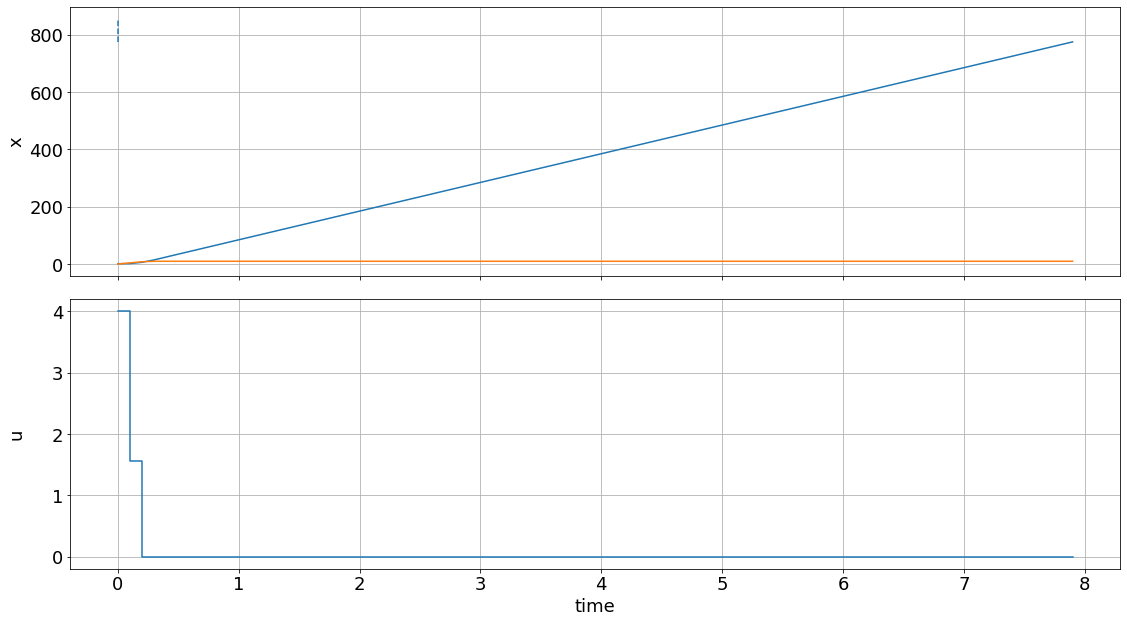

In [55]:
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()

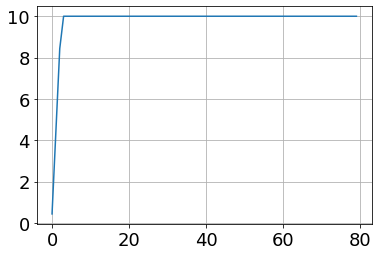

In [56]:
plt.plot(mpc.data['_x'][:,1])

In [57]:
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.8f" % x))
mpc.data['_x'][:100,:]
# array([[1.58367438, 0.43278280],
#        [2.01645718, 1.18908462],
#        [3.20554181, 2.37400576],
#        [5.57954756, 3.74205182],
#        [9.32159939, 5.12021071],

array([[1.58367438, 0.43278280],
       [2.01645718, 4.43278280],
       [6.44923999, 8.43278276],
       [14.88202274, 9.99999997],
       [24.88202272, 10.00000000],
       [34.88202272, 10.00000000],
       [44.88202272, 10.00000000],
       [54.88202272, 10.00000000],
       [64.88202272, 10.00000000],
       [74.88202272, 10.00000000],
       [84.88202272, 10.00000000],
       [94.88202272, 10.00000000],
       [104.88202272, 10.00000000],
       [114.88202272, 10.00000000],
       [124.88202272, 10.00000000],
       [134.88202272, 10.00000000],
       [144.88202272, 10.00000000],
       [154.88202272, 10.00000000],
       [164.88202272, 10.00000000],
       [174.88202271, 10.00000000],
       [184.88202271, 10.00000000],
       [194.88202271, 10.00000000],
       [204.88202271, 10.00000000],
       [214.88202271, 10.00000000],
       [224.88202271, 10.00000000],
       [234.88202271, 10.00000000],
       [244.88202271, 10.00000000],
       [254.88202271, 10.00000000],
       [264

In [58]:
mpc.data['_u'].sum()

9.567217197870127

In [30]:
mpc.data['_x'].shape

(80, 2)

In [31]:
mpc.data['_u'].shape

(80, 1)

In [32]:
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.8f" % x))
mpc.data['_x'][:10,:]


array([[1.58367438, 0.43278280],
       [2.01645718, 1.18908462],
       [3.20554181, 2.37400576],
       [5.57954756, 3.74205182],
       [9.32159939, 5.12021071],
       [14.44181009, 6.39595490],
       [20.83776499, 7.50471218],
       [28.34247717, 8.41798353],
       [36.76046069, 9.13281823],
       [45.89327892, 9.66299747]])

In [33]:
mpc.data.data_fields['_aux'], mpc.data['_opt_aux_num'].shape, mpc.data['success'].shape ,mpc.data['t_wall_total'].shape,  mpc.data['t_wall_total'].sum(),  #mpc.data['_aux']

(1, (80, 8), (80, 1), (80, 1), 0.306622852)

In [56]:
mpc.data.data_fields.keys()

dict_keys(['_time', '_x', '_y', '_u', '_z', '_tvp', '_p', '_aux', '_eps', 'opt_p_num', '_opt_x_num', '_opt_aux_num', '_lam_g_num', 'success', 't_wall_total'])

In [57]:
new_output = list(mpc.data.data_fields.values())
print(" all values in dictionary are:",new_output)

 all values in dictionary are: [1, 2, 2, 1, 0, 0, 0, 1, 0, 3, 26, 8, 18, 1, 1]


In [58]:
mpc.data['_x'].shape

(80, 2)

In [59]:
mpc.data.data_fields

{'_aux': 1,
 '_eps': 0,
 '_lam_g_num': 18,
 '_opt_aux_num': 8,
 '_opt_x_num': 26,
 '_p': 0,
 '_time': 1,
 '_tvp': 0,
 '_u': 1,
 '_x': 2,
 '_y': 2,
 '_z': 0,
 'opt_p_num': 3,
 'success': 1,
 't_wall_total': 1}

In [60]:
dir(mpc.data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_aux',
 '_eps',
 '_lam_g_num',
 '_opt_aux_num',
 '_opt_x_num',
 '_p',
 '_time',
 '_tvp',
 '_u',
 '_x',
 '_y',
 '_z',
 'data_fields',
 'dtype',
 'export',
 'init_storage',
 'meta_data',
 'model',
 'opt_aux',
 'opt_p',
 'opt_p_num',
 'opt_x',
 'prediction',
 'prediction_queries',
 'result_queries',
 'set_meta',
 'success',
 't_wall_total',
 'update']

In [ ]:
sqrt((-4)**2)

4.0

In [59]:
import casadi as ca

In [61]:
xgrid=np.linspace(1,6,6)
V=[-1,-1,-2,-3,0,2]
lut=ca.interpolant('LUT', 'bspline', [xgrid], V)

print(lut(1),lut(2),lut(3), lut(5.),lut(6) ,lut(5.3), lut(5.35),lut(6.),lut(7.),)

-1 -1 -2 -2.22045e-16 2 1.0508 1.20277 2 0


In [64]:
type(lut)

casadi.casadi.Function